In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from __future__ import print_function

In [2]:
def get_s_y(arr):
    # рисует что-то типа плотности вероятности для переданного листа
    support = np.array([[i/1000] for i in range(50, 1000, 10)])
    y = [len(arr[np.abs(elem - arr) <= 0.005]) for elem in support]
    return support, y

def norm(evaluated_gradients):
    # Вычисляет норму переданных градиентов
    kek = np.array([])
    for elem in evaluated_gradients:
        kek = np.append(kek, elem)
    return np.linalg.norm(kek)

Генерируем датасет и рисуем плотность

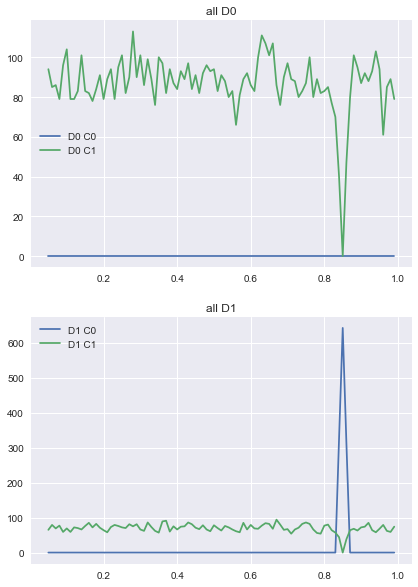

In [6]:
C0_size = 1280
C1_size = 16000
center = 0.85

C0 = np.random.uniform(low=0.84, high=0.86, size=C0_size)
C1 = np.random.uniform(low=0, high=1, size=(C1_size,))
C1 = C1[[i for i,elem in enumerate(C1) if (np.abs(elem-center) >= 0.01) ]]

dataset = np.concatenate((C0, C1), axis=0)
C1_labels = np.concatenate(([0]*len(C0), [1]*len(C1)))
D1_labels = np.arange(len(dataset))

D1_labels[C1_labels==0] = np.random.binomial(1, 1, size=(len(C1_labels) - C1_labels.sum(),))
D1_labels[C1_labels==1] = np.random.binomial(1, 0.45, size=(C1_labels.sum(),))

plt.figure(figsize=(15,10))

plt.subplot(221)
plt.title('all D0')
s, p1 = get_s_y(dataset[(C1_labels==0) * (D1_labels==0)])
s, p2 = get_s_y(dataset[(C1_labels==1) * (D1_labels==0)])
plt.plot(s, p1, label='D0 C0')
plt.plot(s, p2, label='D0 C1')
plt.legend()

plt.subplot(223)
plt.title('all D1')
s, p3 = get_s_y(dataset[(C1_labels==0) * (D1_labels==1)])
s, p4 = get_s_y(dataset[(C1_labels==1) * (D1_labels==1)])
plt.plot(s, p3, label='D1 C0')
plt.plot(s, p4, label='D1 C1')
plt.legend()

plt.show()

Генерируем разбиение на пары. Два объекта близки, если  близки их l1 нормы (вспомогательного классификатора нет). На слово svm внимания не обращать

In [7]:
d1 = dataset[D1_labels == 1]
d0 = dataset[D1_labels == 0]

pairs = np.zeros((len(d1), 2), dtype=int)
pairs[:,1] = np.arange(len(d1))

svm_preds_d1 = d1.reshape(-1)
svm_preds_d0 = d0.reshape(-1)

svm_preds_d0_temp = svm_preds_d0.copy()
svm_preds_d0_arange = np.arange(0,len(svm_preds_d0))
for i in range(len(pairs)-1, 0, -1):
    temp = np.argmin(np.abs(svm_preds_d1[i] - svm_preds_d0_temp))
    pairs[i, 0] = svm_preds_d0_arange[temp]
    svm_preds_d0_temp = np.delete(svm_preds_d0_temp, temp)
    svm_preds_d0_arange = np.delete(svm_preds_d0_arange, temp)

In [8]:
def create_nn():
    
    global input_layer, W1,b1,c1, W2,b2,c2, W3,b3,c3, W4,b4,logits, y, y_, constants, loss, train_step, trainable, grads, correct_prediction, accuracy, sess
    
    input_layer = tf.placeholder(tf.float32, [None, 1])

    W1 = tf.Variable(np.random.randn(1,128).astype(np.float32))
    b1 = tf.Variable(np.random.randn(128).astype(np.float32))
    c1 = tf.nn.tanh(tf.matmul(input_layer, W1) + b1)

    W2 = tf.Variable(np.random.randn(128,64).astype(np.float32))
    b2 = tf.Variable(np.random.randn(64).astype(np.float32))
    c2 = tf.nn.tanh(tf.matmul(c1, W2) + b2)

    W3 = tf.Variable(np.random.randn(64,32).astype(np.float32))
    b3 = tf.Variable(np.random.randn(32).astype(np.float32))
    c3 = tf.nn.tanh(tf.matmul(c2, W3) + b3)

    W4 = tf.Variable(np.random.randn(32,1).astype(np.float32))
    b4 = tf.Variable(np.random.randn(1).astype(np.float32))
    logits = tf.matmul(c3, W4) + b4
    y = tf.nn.sigmoid(logits)

    y_ = tf.placeholder(tf.float32, [None, 1])
    
    # коэффициенты для слагаемых кроссэнтропии
    constants = tf.placeholder(tf.float32, [None, 1]) 
    
    # кроссэнтропия, со "слотом" для коэффициентов
    loss = tf.reduce_sum(
        tf.multiply(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_, logits=logits),
                   constants)
        )
    train_step = tf.train.AdamOptimizer().minimize(loss)

    trainable = [W1,W2,W3,W4,b1,b2,b3,b4]
    grads = tf.gradients(loss, trainable)

    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    sess = tf.InteractiveSession()
    tf.global_variables_initializer().run()

In [9]:
# сюда складываем значения лоссов и вероятностей, на i-м месте - i-я сетка 
global_storage_losses = []
global_storage_probs = []

# коэффициенты, соответствующие обычному лоссу (сэмплы из равномерного распределения)
c = np.array([1]*len(pairs)).reshape(-1,1)

for heh_mda in tqdm_notebook(range(50)): # большой цикл, в каждом обучается своя сетка (потом по ним усредняем)
    
    create_nn()
    
    # сюда складываем значения лоссов и вероятностей, на j-м месте - j-я эпоха
    local_storage_losses = []
    local_storage_probs = []
    
    # изначально сэмплим равномерно
    probs = np.array([1/len(pairs)]*len(pairs))
    
    for _ in tqdm_notebook(range(60), leave=False): # цикл обучения
        
        # посреди пути пересчитываем вероятности пропорционально норме градиента
        if _ == 30:
            probs = np.zeros((len(pairs),))
            for i,elem in enumerate(pairs): # пересчитываем вероятности
                batch_of_two = np.array([d0[elem[0]],d1[elem[1]]]).reshape(2,-1)
                probs[i] = norm(sess.run(grads, feed_dict={input_layer:batch_of_two, 
                                                           y_:np.array([[0],[1]]),
                                                           constants:np.array([c[i], c[i]]).reshape(-1,1)}))
            probs = (probs) / (probs).sum()
        
        local_storage_probs.append(probs.reshape(1,-1))
        
        
        # генерируем батч в соответсвии с текущим распределением
        nice = np.random.choice(np.arange(len(pairs)), size=10000, p=probs)
        nice = pairs[nice]
        nice_batch = np.array([])
        nice_batch_y = np.array([])
        nice_batch = np.append(nice_batch, d0[nice[:,0]])
        nice_batch_y = np.append(nice_batch_y, np.zeros((len(nice),), dtype=int))
        nice_batch = np.append(nice_batch, d1[nice[:,1]])
        nice_batch_y = np.append(nice_batch_y, np.ones((len(nice),), dtype=int))
        
        # находим новые коэффициенты в лоссе (чтобы мат.ожидаение не сместилось)
        c_temp = (np.array([1/len(pairs)]*len(pairs)) / probs)[nice[:,1]]
        c_temp = c_temp.reshape(-1,1)
        
        # производим шаг обучения
        l,_ = sess.run([loss, train_step], feed_dict={input_layer: nice_batch.reshape(-1,1),
                                                      y_: nice_batch_y.reshape(-1,1),
                                                      constants: np.concatenate([c_temp,c_temp])})
        
        # вычисляем ошибку на данном батче на лоссе с !обычными! коэффициентами
        # (чисто для статистики, содержательно эта величина не используется)
        ol = np.array([1/len(pairs)]*len(pairs)).reshape(-1,1)[nice[:,1]]
        local_storage_losses.append(sess.run([loss], feed_dict={input_layer: nice_batch.reshape(-1,1),
                                                      y_: nice_batch_y.reshape(-1,1),
                                                      constants: np.concatenate([ol,ol])}))
        
    global_storage_losses.append(local_storage_losses)
    global_storage_probs.append(local_storage_probs)

Рисуем усреднённую динамику лосса (кроме 10% плохих случаев)

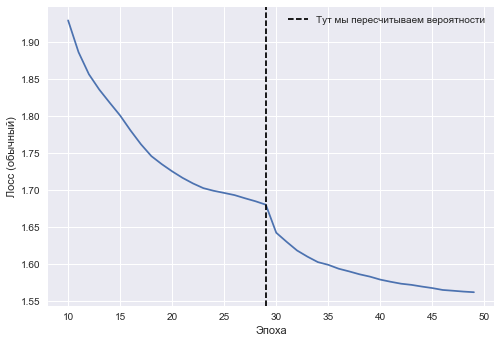

In [13]:
plt.plot(np.arange(10,50), np.array(global_storage_losses)[(np.array(global_storage_losses)[:,30,:] < 2).reshape(-1)][:,10:50,:].mean(axis=0))
plt.axvline(x=29, color='k', linestyle='--', label='Тут мы пересчитываем вероятности')
plt.xlabel('Эпоха')
plt.ylabel('Лосс (обычный)')
plt.legend()
plt.show()

Рисуем динамику изменения вероятностей

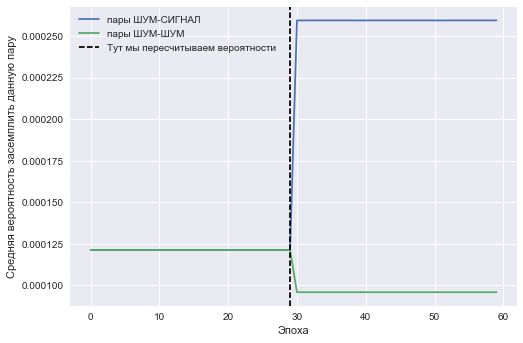

In [15]:
lel = np.array(global_storage_probs).mean(axis=0)
plt.plot(np.mean(lel[:,0,:1280],axis=1), label='пары ШУМ-СИГНАЛ')
plt.plot(np.mean(lel[:,0,1280:],axis=1), label='пары ШУМ-ШУМ')
plt.axvline(x=29, color='k', linestyle='--', label='Тут мы пересчитываем вероятности')
plt.xlabel('Эпоха')
plt.ylabel('Средняя вероятность засемплить данную пару')
plt.legend()
plt.show()

Таким образом, в среднем, одного пересчёта вероятностного распределения над объектами обучающей выборки на середине пути в этой задаче хватает для увеличения вероятности засемплить "хорошие" пары в два раза, что приводит к "пробитию" лоссом более низкой планки.